In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load JSON file
data_path = os.path.join("data", "bot.json") 
with open(data_path, "r", encoding="utf-8") as file:
    chat_data = json.load(file)


In [3]:
# Convert JSON to DataFrame
df = pd.DataFrame(chat_data['messages'])
df.tail()

,id,type,date,date_unixtime,actor,actor_id,action,title,text,text_entities,...,game_message_id,score,saved_from,location_information,invoice_information,place_name,address,reply_to_peer_id,giveaway_information,boosts
474259,945379,message,2024-12-01T17:03:44,1733061824,NaN,NaN,NaN,NaN,"[{'type': 'mention', 'text': '@BotFather'}, >...","[{'type': 'mention', 'text': '@BotFather'}, {'...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474260,945381,message,2024-12-01T17:07:05,1733062025,NaN,NaN,NaN,NaN,Thanks for your help),"[{'type': 'plain', 'text': 'Thanks for your he...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474261,945382,message,2024-12-01T17:10:09,1733062209,NaN,NaN,NaN,NaN,"Can i edit message with media, and delete medi...","[{'type': 'plain', 'text': 'Can i edit message...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474262,945385,message,2024-12-01T17:42:28,1733064148,NaN,NaN,NaN,NaN,Why you ignore me?,"[{'type': 'plain', 'text': 'Why you ignore me?'}]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474263,945386,message,2024-12-01T17:43:00,1733064180,NaN,NaN,NaN,NaN,Because your message doesn't make sense. What ...,"[{'type': 'plain', 'text': 'Because your messa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


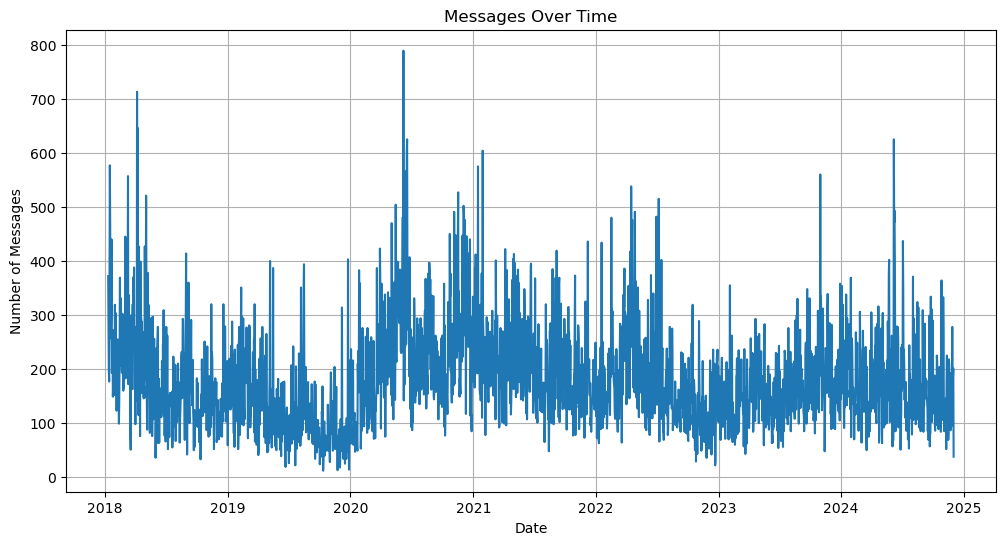

In [4]:
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

# Filter only text messages
text_messages = df[df['type'] == 'message']

# Plot messages over time
plt.figure(figsize=(12, 6))
text_messages['date'].dt.date.value_counts().sort_index().plot(kind='line')
plt.title("Messages Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Messages")
plt.grid()
plt.show()

In [5]:
# Step 1: Extract the relevant columns (just text)
df = pd.DataFrame(chat_data['messages'])
df = df[['text']]  # Keep only the text column
df.head()

,text
0,
1,
2,
3,
4,


In [6]:
# Step 2: Remove rows with null or empty text
df = df[df['text'].notna() & (df['text'].str.strip() != '')]
df.head()

,text
8,[Hey! This is a chat where you can talk about...
26,Hello for everyone! My name is Davronbek Rusta...
29,Welcome everyone!
32,Hello! \(^-^)/
36,Bonjour


In [7]:
# Step 3: Remove emojis (non-ASCII characters)
df['text'] = df['text'].str.replace(r'[^\x00-\x7F]+', '', regex=True)
df.head()

,text
8,NaN
26,Hello for everyone! My name is Davronbek Rusta...
29,Welcome everyone!
32,Hello! \(^-^)/
36,Bonjour


In [8]:

# Step 4: Remove special characters, numbers, and punctuation (keep only alphabets and spaces)
df['text'] = df['text'].str.replace(r"[^a-zA-Z\s]", '', regex=True)
df.tail()

,text
474259,NaN
474260,Thanks for your help
474261,Can i edit message with media and delete media...
474262,Why you ignore me
474263,Because your message doesnt make sense What is...


In [9]:
# Step 5: Convert text to lowercase and strip extra spaces, and NaN values
df['text'] = df['text'].str.lower().str.strip()
df['text'] = df['text'].fillna('')
df.tail()

,text
474259,
474260,thanks for your help
474261,can i edit message with media and delete media...
474262,why you ignore me
474263,because your message doesnt make sense what is...


In [10]:
# Step 6: Remove short messages (less than 3 characters) and duplicates
df = df[df['text'].str.len() > 3]
df = df.drop_duplicates(subset=['text'], keep='first')
df.head()

,text
26,hello for everyone my name is davronbek rustam...
29,welcome everyone
32,hello
36,bonjour
44,bonjour love


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000)  # You can adjust the number of features

# Fit the model and transform the text data
X_tfidf = tfidf.fit_transform(df['text'])

# Check the shape of the transformed data
print(X_tfidf.shape)

#save
import joblib
joblib.dump(tfidf, 'models/tfidf_vectorizer.pkl')

(306625, 10000)


['models/tfidf_vectorizer.pkl']

In [13]:
# use VADER  for adding sentiment common to the data
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Assuming df is your existing DataFrame with 'text' column
df['sentiment'] = df['text'].apply(lambda x: 'positive' if analyzer.polarity_scores(x)['compound'] > 0 
                                   else 'negative' if analyzer.polarity_scores(x)['compound'] < 0 
                                   else 'neutral')

# Display the first 200 rows of the DataFrame to inspect the sentiment column
print(df.head(2000))




                                                   text sentiment
26    hello for everyone my name is davronbek rustam...  positive
29                                     welcome everyone  positive
32                                                hello   neutral
36                                              bonjour   neutral
44                                         bonjour love  positive
...                                                 ...       ...
3084                          can you make a bot for me   neutral
3086  this place is more for those actively developi...  positive
3092  i want to ask \ni have made menu and sub menu ...  negative
3094                                     this is my bot   neutral
3095                 i want my user submit order by bot  positive

[2000 rows x 2 columns]


In [20]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Encode the sentiment labels
y = label_encoder.fit_transform(df['sentiment'])

#save
joblib.dump(label_encoder, 'models/label_encoder.pkl')

# Check the label encoding
print(label_encoder.classes_)
print(y[:100])  # Display the first 10 encoded labels
df.head(1000)


['negative' 'neutral' 'positive']
[2 2 1 1 2 2 0 1 0 0 1 2 2 1 1 1 0 1 2 1 1 1 0 1 1 1 2 1 0 2 2 1 2 1 1 2 2
 1 1 1 1 2 2 1 1 1 0 1 0 1 0 1 1 0 2 1 1 2 0 1 1 2 2 1 1 2 1 1 1 2 1 1 1 2
 2 1 1 1 1 1 1 2 2 2 1 2 2 1 2 0 0 2 2 1 1 1 1 1 2 2]


,text,sentiment
26,hello for everyone my name is davronbek rustam...,positive
29,welcome everyone,positive
32,hello,neutral
36,bonjour,neutral
44,bonjour love,positive
...,...,...
1667,eh choose language,neutral
1669,found this really cool maybe help later with g...,positive
1670,do you guys have good open source bots written...,positive
1671,cheers youre the best,positive


In [21]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Check the shape of the train and test data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



(245300, 10000) (61325, 10000) (245300,) (61325,)


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.86      0.74      0.80     11029
           1       0.95      0.99      0.97     28652
           2       0.90      0.91      0.91     21644

    accuracy                           0.92     61325
   macro avg       0.91      0.88      0.89     61325
weighted avg       0.92      0.92      0.92     61325



In [16]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for Logistic Regression
param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}

# GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best model found by GridSearchCV
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))


Best parameters: {'C': 10, 'solver': 'liblinear'}
Best score: 0.9496614695829526
              precision    recall  f1-score   support

           0       0.87      0.79      0.83     12133
           1       0.99      1.00      0.99     49687
           2       0.92      0.94      0.93     27242

    accuracy                           0.95     89062
   macro avg       0.93      0.91      0.92     89062
weighted avg       0.95      0.95      0.95     89062



In [22]:
import os
import joblib


os.makedirs('models', exist_ok=True)


joblib.dump(model, 'models/sentiment_model.pkl')

print("Model saved in 'models/sentiment_model.pkl'")



Model saved in 'models/sentiment_model.pkl'


In [23]:
import joblib

model = joblib.load('models/sentiment_model.pkl')
print(model)



LogisticRegression(max_iter=1000)


In [24]:
# Example new data
new_chat_messages = [
    "I love this feature!",
    "This is the worst experience ever.",
    "Nothing will happen.",
    "i have no mentor",
    "no sound"
]

# Preprocess the new data (same as the training data)
new_data_tfidf = tfidf.transform(new_chat_messages)

# Predict sentiment for the new messages
predictions = model.predict(new_data_tfidf)

# Decode the predictions to original labels
sentiment_labels = label_encoder.inverse_transform(predictions)

# Print results
for message, sentiment in zip(new_chat_messages, sentiment_labels):
    print(f"Message: {message}\nPredicted Sentiment: {sentiment}\n")


Message: I love this feature!
Predicted Sentiment: positive

Message: This is the worst experience ever.
Predicted Sentiment: negative

Message: Nothing will happen.
Predicted Sentiment: neutral

Message: i have no mentor
Predicted Sentiment: negative

Message: no sound
Predicted Sentiment: negative

